# Autoencoder in Jax + Flax 

## 1. Data 

In [127]:
from util import *
import pickle
in_file = open('norm_fmnist.pkl', 'rb')
d_set = pickle.load(in_file)  # training set 

In [128]:
new_in_file = open('test_norm_fmnist.pkl', 'rb')
test_set = pickle.load(new_in_file)

Visualize a sample: 

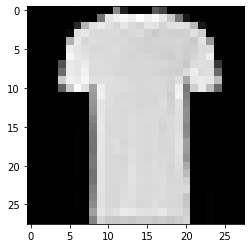

In [126]:
plot_numpy_img(d_set[55][0].reshape(28,28), False)

## 2. Build and initialize the model 

In [129]:
import jax
import jax.numpy as jnp                # JAX NumPy
from flax import linen as nn           # The Linen API
import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers

In [130]:
latent_dims = 20

class AE(nn.Module):
  @nn.compact
  def __call__(self, x):
    # encoder 
    x = jnp.reshape(x, -1) 
    x = nn.Dense(features=784)(x)
    x = nn.relu(x)
    x = nn.Dense(features=512)(x)
    x = nn.relu(x)
    x = nn.Dense(features=latent_dims)(x)
    
    # decoder 
    x = nn.Dense(features=512)(x)
    x = nn.relu(x)
    x = nn.Dense(features=784)(x)
    x = nn.sigmoid(x)
    return x.reshape(28, 28)

In [131]:
autoencoder = AE()
sample_batch = jnp.ones((1,28,28))
params = autoencoder.init(jax.random.PRNGKey(0), sample_batch)  # model param that we'll train 

Let's see what our model reconstructs on the above sample without trained parameters...

In [132]:
gen_sample = autoencoder.apply(params, d_set[0][0])

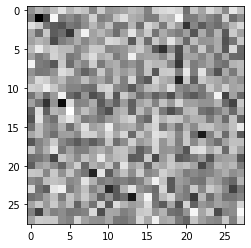

In [133]:
plot_numpy_img(gen_sample, False)

Blur! 

## 3. Training 

Loss is defined as used [here](https://avandekleut.github.io/vae/).   

In [134]:
def reconstruction_loss(original_im, reconstructed_im):
    original_im = original_im.reshape(28, 28)
    loss = ((original_im - reconstructed_im)**2).sum()
    return loss

In [135]:
# test to confirm loss produces an output
reconstruction_loss(d_set[0][0], gen_sample)

DeviceArray(121.41552, dtype=float32)

In [136]:
# forward loss 
# Same as version above but with model.apply().
@jax.jit  # wrap in jit for speed-up! 
def forward_loss(params, original_im):
    reconstructed_im = autoencoder.apply(params, original_im)
    return reconstruction_loss(original_im, reconstructed_im).mean()  # use mean to extract value 

In [137]:
# test to confirm loss produces an output (should be same value as the above function)
forward_loss(params, d_set[0][0])

DeviceArray(121.41552, dtype=float32)

In [138]:
LR = 0.001
tx = optax.sgd(learning_rate=LR)  # tx is the optimizer 
opt_state = tx.init(params)  # tx needs a state that we init here 
# wrap loss func in function that will simultaneously calculate value and gradient
loss_grad_fn = jax.value_and_grad(forward_loss)  

**Training loop**: 

In [139]:
NUM_EPOCHS = 20
losses = []

for i in range(NUM_EPOCHS):
    batch_loss = 0
    
    for sample in d_set:
        x = sample[0]
        # no need for y since this is unsupervised 
        
        # update params  (note: eventually wrap this in function so that you can jit it) 
        loss_val, grads = loss_grad_fn(params, x)
        batch_loss += loss_val  # record sample loss 
        updates, opt_state = tx.update(grads, opt_state)
        params =  optax.apply_updates(params, updates)  # updating of params
    
    epoch_loss = batch_loss/len(d_set)
    losses.append(epoch_loss)
    print('Loss step {}: '.format(i + 1), epoch_loss)

Loss step 1:  115.37869
Loss step 2:  73.74458
Loss step 3:  51.167336
Loss step 4:  42.87034
Loss step 5:  40.424004
Loss step 6:  38.392986
Loss step 7:  36.286636
Loss step 8:  34.539875
Loss step 9:  33.095356
Loss step 10:  31.926682
Loss step 11:  30.612942
Loss step 12:  29.597532
Loss step 13:  28.338943
Loss step 14:  27.364285
Loss step 15:  26.207104
Loss step 16:  25.34774
Loss step 17:  24.752407
Loss step 18:  24.220148
Loss step 19:  23.418156
Loss step 20:  23.1104


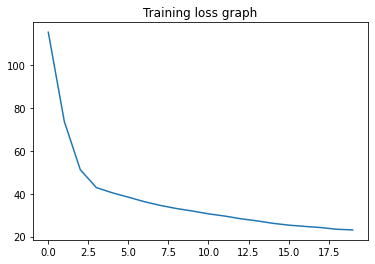

In [140]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training loss graph")
plt.show()

## Evaluate! 

In [141]:
# now lets try again with the previous sample now that we have trained params...
gen_new_sample = autoencoder.apply(params, d_set[55][0])

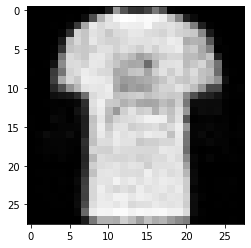

In [142]:
plot_numpy_img(gen_new_sample, False)

Wow!... pretty close to the sample above. Now let's run the model on the test set... 

Original image


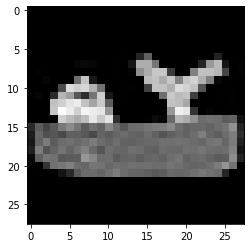

Reconstructed image


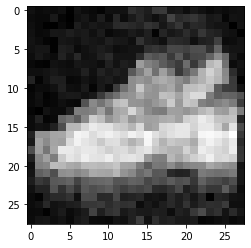

Original image


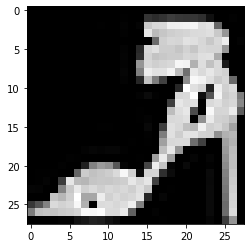

Reconstructed image


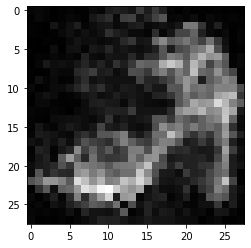

Original image


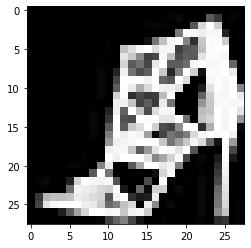

Reconstructed image


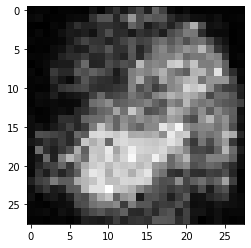

Original image


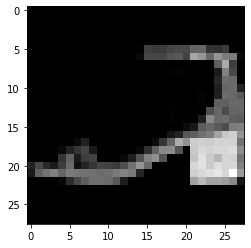

Reconstructed image


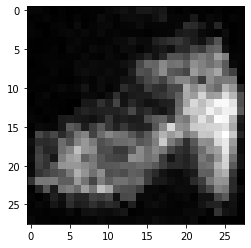

Original image


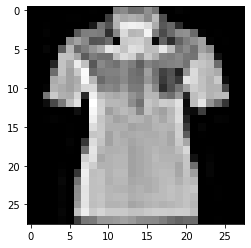

Reconstructed image


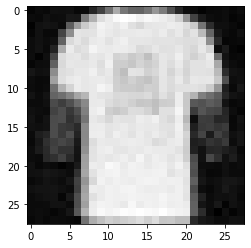

Original image


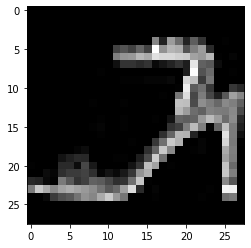

Reconstructed image


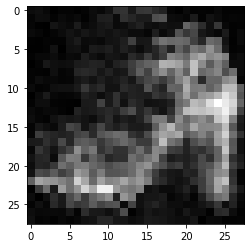

Original image


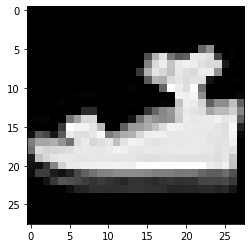

Reconstructed image


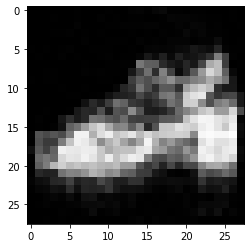

Original image


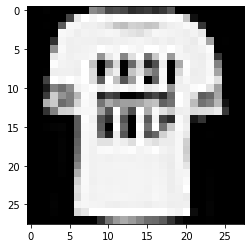

Reconstructed image


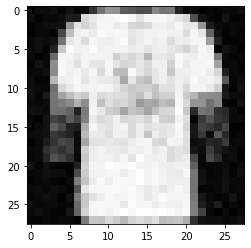

Original image


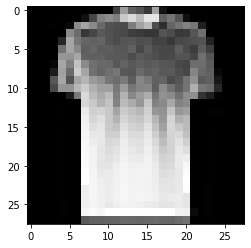

Reconstructed image


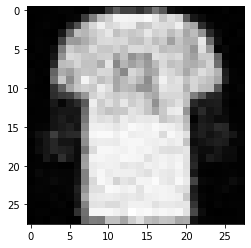

Original image


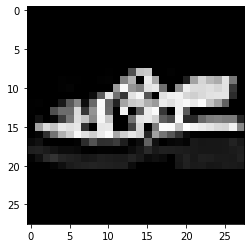

Reconstructed image


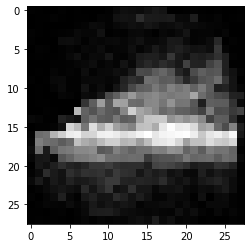

Original image


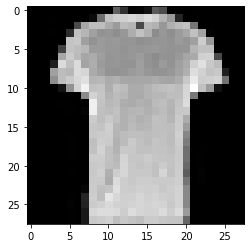

Reconstructed image


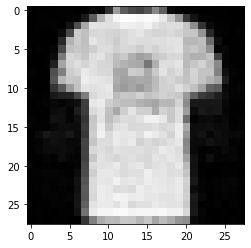

Original image


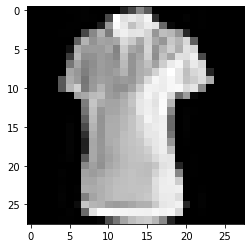

Reconstructed image


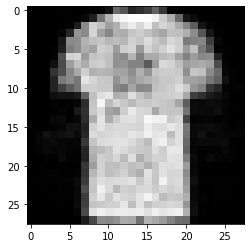

Original image


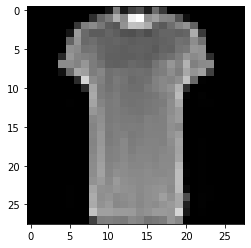

Reconstructed image


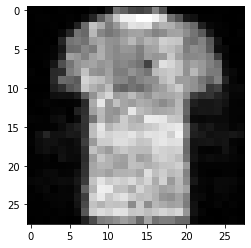

Original image


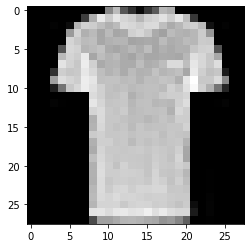

Reconstructed image


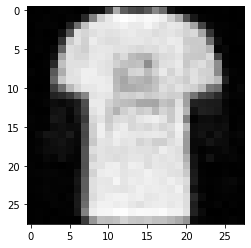

Original image


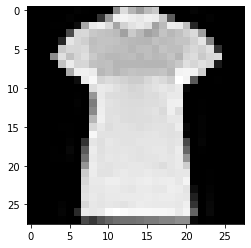

Reconstructed image


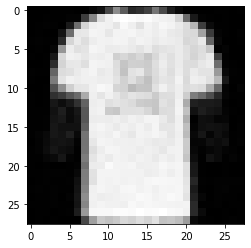

Original image


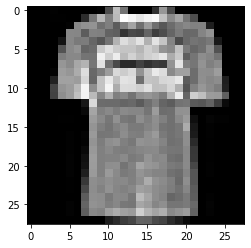

Reconstructed image


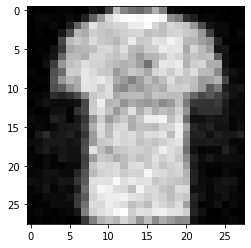

Original image


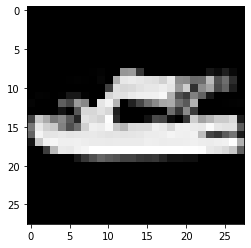

Reconstructed image


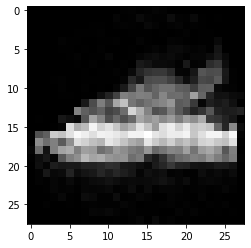

Original image


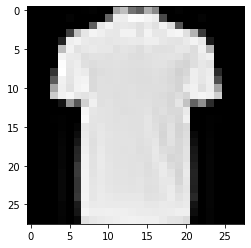

Reconstructed image


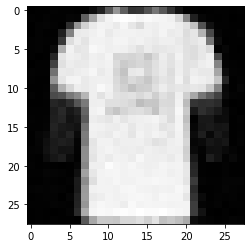

Original image


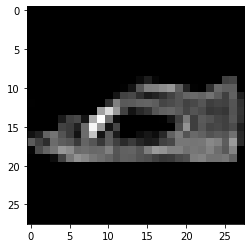

Reconstructed image


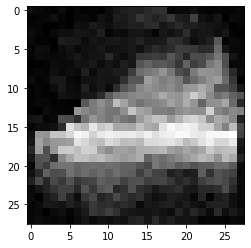

Original image


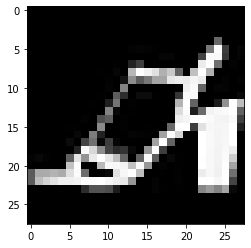

Reconstructed image


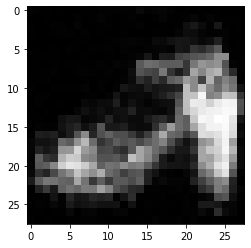

In [149]:
for sample in test_set:
    og_img = sample[0]
    print("Original image")
    plot_numpy_img(og_img, color=False)
    reconstructed_img = autoencoder.apply(params, og_img)
    print("Reconstructed image")
    plot_numpy_img(reconstructed_img, color=False)